## 试题说明

### 任务描述
近年来，随着人工智能的发展，其在语音识别、自然语言处理、图像与视频分析等诸多领域取得了巨大成功。随着政府对环境保护的呼吁，垃圾分类成为一个亟待解决的问题，本次竞赛将聚焦在垃圾图片的分类，利用人工智能技术，对居民生活垃圾图片进行检测，找出图片中有哪些类别的垃圾。
要求参赛者给出一个算法或模型，对于给定的图片，检测出图片中的垃圾类别。给定图片数据，选手据此训练模型，为每张测试数据预测出最正确的类别。

### 数据说明
本竞赛所用训练和测试图片均来自生活场景。总共四十个类别，类别和标签对应关系在训练集中的dict文件里。图片中垃圾的类别，格式是“一级类别/二级类别”，二级类别是具体的垃圾物体类别，也就是训练数据中标注的类别，比如一次性快餐盒、果皮果肉、旧衣服等。一级类别有四种类别：可回收物、厨余垃圾、有害垃圾和其他垃圾。

数据文件包括训练集(有标注)和测试集(无标注)，训练集的所有图片分别保存在train文件夹下面的0-39个文件夹中，文件名即类别标签，测试集共有400张待分类的垃圾图片在test文件夹下，testpath.txt保存了所有测试集文件的名称，格式为：name+\n。

![](https://ai-studio-static-online.cdn.bcebos.com/cec625e7b61d459fa13ed2b822817bfd57030ad23c524f1ab93b3e7108d75d78)
![](https://ai-studio-static-online.cdn.bcebos.com/df06e2956f2044fab21fde2a9602abfdb9d4720861d54c66b2e079f3e64000a7)

### 提交答案
考试提交，需要提交**模型代码项目版本**和**结果文件**。结果文件为TXT文件格式，命名为model_result.txt，文件内的字段需要按照指定格式写入。

提交结果的格式如下：
1. 每个类别的行数和测试集原始数据行数应一一对应，不可乱序。
2. 输出结果应检查是否为400行数据，否则成绩无效。
3. 输出结果文件命名为model_result.txt，一行一个类别标签（数字）


样例如下：

···

35

3

2

37

10

3

26

4

34

21

···


In [1]:
### 开始答题

In [2]:
import os
import math 
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
from PIL import ImageEnhance
import paddle.fluid as fluid
import matplotlib.pyplot as plt

# **参数配置**

In [3]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 64, 64],                                #输入图片的shape，图片大小
    "class_dim": -1,                                          #分类数
    "src_path":"data/data35095/train.zip",                    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "test_list_path":"/home/aistudio/data/test.txt",          #test.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 60,                                         #训练轮数
    "train_batch_size": 400,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.005                                          #超参数学习率
    } 
}

# **一、数据准备（类似美食分类）**

### （1）解压原始数据集

### （2）按照比例划分训练集与验证集

### （3）乱序，生成数据列表

### （4）构造训练数据集提供器和验证数据集提供器

In [4]:
# 解压
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "train")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [5]:
#图像增强,直接copy美食的
def data_enhance(target_path):
    i = 0
    dirs = os.listdir(target_path)
    print(dirs)
    if '__MACOSX' in dirs:
        dirs.remove('__MACOSX')
    for sdir in dirs:
        rootdir = target_path + '/' + sdir
        print(rootdir)
        for parent, dirnames, filenames in os.walk(rootdir):
            # print('parent is :' + parent)
            for filename in filenames:
                if filename == '.DS_Store':
                    continue
                i = i + 1
                currentPath = os.path.join(parent, filename)
                if 'rsi' not in currentPath:
                    img = Image.open(currentPath)
                    if img.mode == "P":
                        img = img.convert('RGB')
                    random_factor = np.random.randint(0, 31) / 10.  # 随机因子
                    color_image = ImageEnhance.Color(img).enhance(random_factor)  # 调整图像的饱和度
                    random_factor = np.random.randint(10, 21) / 10.  # 随机因子
                    brightness_image = ImageEnhance.Brightness(color_image).enhance(random_factor)  # 调整图像的亮度
                    random_factor = np.random.randint(10, 21) / 10.  # 随机因子
                    contrast_image = ImageEnhance.Contrast(brightness_image).enhance(random_factor)  # 调整图像对比度
                    random_factor = np.random.randint(0, 31) / 10.  # 随机因子
                    sharpness_image = ImageEnhance.Sharpness(contrast_image).enhance(random_factor)
                    out = sharpness_image
                    newname = rootdir + "/rsi_" + filename
                    if not os.path.exists(newname):
                        out.save(newname)
                    

In [6]:

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"train/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [7]:
# 同样copy美食
def custom_reader(file_list):
    '''
    自定义reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = Image.open(img_path) 
                if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                img = img.resize((64, 64), Image.BILINEAR)  #图像全部转换成64x64的大小，并且二值化处理
                img = np.array(img).astype('float32') 
                img = img.transpose((2, 0, 1))  # HWC to CHW 
                img = img/255                   # 像素值归一化 
                yield img, int(lab) 
    return reader


In [8]:
'''
参数初始化,主函数开始
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
test_list_path=train_parameters['test_list_path']
batch_size=train_parameters['train_batch_size']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)
#data_enhance(target_path+"train")
'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt，清空文件夹
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 


    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

'''
构造数据提供器
'''
train_reader = paddle.batch(custom_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)      #若设置为True，则当最后一个batch不等于batch_size时，丢弃最后一个batch；若设置为False，则不会。默认值为False。
eval_reader = paddle.batch(custom_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)


生成数据列表完成！


# **二、模型卷积神经网络配置**



In [9]:

#定义卷积网络CNN，2*(2*卷积+池化)，效果不好
class MyCNN(fluid.dygraph.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.hidden1 = fluid.dygraph.Conv2D(num_channels=3,       #通道数，就是卷积层的厚度
                                            num_filters=64,       #卷积核个数
                                            filter_size=3,        #卷积核大小，总的卷积核，大小是(3*3*Chanel)*num
                                            stride=1)             #步长
        self.hidden2 = fluid.dygraph.Conv2D(num_channels=64,
                                            num_filters = 128,
                                            filter_size=3,
                                            stride=1)
        self.hidden3 = fluid.dygraph.Pool2D(pool_size=2,          #池化核大小
                                            pool_type='max',      #池化类型
                                            pool_stride=2)        #池化步长
        self.hidden4 = fluid.dygraph.Conv2D(num_channels=128,       #通道数，就是卷积层的厚度
                                            num_filters=256,       #卷积核个数
                                            filter_size=3,        #卷积核大小，总的卷积核，大小是(3*3*Chanel)*num
                                            stride=1)             #步长
        self.hidden5 = fluid.dygraph.Conv2D(num_channels=256,
                                            num_filters = 256,
                                            filter_size=3,
                                            stride=1)
        self.hidden6 = fluid.dygraph.Pool2D(pool_size=2,          #池化核大小
                                            pool_type='max',      #池化类型
                                            pool_stride=2)        #池化步长                                    
        self.hidden7 = fluid.dygraph.Linear(256*13*13,40,act='softmax')   #softmax层与上一层的维度相同，反正全连接了,卷积层不补边
    #网络的前向计算过程，通过forward函数把上面定义的各层连接起来
    def forward(self,input):
        # print(input.shape)   #64,3,64,64
        x = self.hidden1(input)
        #print(x.shape)
        x = self.hidden2(x)
        #print(x.shape)
        x = self.hidden3(x)
        #print(x.shape)
        x = self.hidden4(x)
        #print(x.shape)
        x = self.hidden5(x)
        #print(x.shape)
        x = self.hidden6(x)
        #print(x.shape)
        #卷积层的输出特征图如何当作全连接层的输入使用呢？
        #卷积层的输出数据格式是[N,C,H,W],在输入全连接层的时候，会自动将数据拉平.
        #也就是对每个样本，自动将其转化为长度为K的向量，其中K=C×H×W，一个mini-batch的数据维度变成了N×K的二维向量。
        # N表示输入的样本个数，即batch_size
        # C表示图像的通道数
        # H表示图像的高度
        # W表示图像的宽度
        # print(x.shape)   #[64, 256, 13, 13]
        x = fluid.layers.reshape(x, shape=[-1, 256*13*13])  #这里对卷积层的输出reshape了
        # print(x.shape)      # [64, 43264]
        y = self.hidden7(x)
        # print(y.shape)    # [64, 40]
        return y




In [10]:
# VGG16
class ConvBlock(fluid.dygraph.Layer):
    """
    卷积+池化
    """
    def __init__(self, name_scope, num_channels, num_filters, groups):
        """构造函数"""
        super(ConvBlock, self).__init__(name_scope)

        self._conv2d_list = []
        init_num_channels = num_channels
        for i in range(groups):
            conv2d = self.add_sublayer(
                'bb_%d' % i,
                fluid.dygraph.Conv2D(
                    init_num_channels, num_filters=num_filters, filter_size=3,
                    stride=1, padding=1, act='relu'
                )
            )
            self._conv2d_list.append(conv2d)
            init_num_channels = num_filters

        self._pool = fluid.dygraph.Pool2D(
            pool_size=2, pool_type='max', pool_stride=2
        )

    def forward(self, inputs):
        """前向计算"""
        x = inputs
        for conv in self._conv2d_list:
            x = conv(x)
        x = self._pool(x)
        return x


class VGGNet(fluid.dygraph.Layer):
    """
    VGG网络
    """
    def __init__(self, name_scope, layers=16, class_dim=40):
        """
        构造函数
        :param name_scope:   命名空间
        :param layers:       具体的层数如VGG-16、VGG-19等
        :param class_dim     分类的数量
        """
        super(VGGNet, self).__init__(name_scope)
        self.vgg_spec = {
            11: ([1, 1, 2, 2, 2]),
            13: ([2, 2, 2, 2, 2]),
            16: ([2, 2, 3, 3, 3]),
            19: ([2, 2, 4, 4, 4])
        }
        assert layers in self.vgg_spec.keys(), \
            "supported layers are {} but input layer is {}".format(self.vgg_spec.keys(), layers)
        
        #需要修改groups
        nums = self.vgg_spec[layers]
        self.conv1 = ConvBlock(self.full_name(), num_channels=3, num_filters=64, groups=2)
        self.conv2 = ConvBlock(self.full_name(), num_channels=64, num_filters=128, groups=2)
        self.conv3 = ConvBlock(self.full_name(), num_channels=128, num_filters=256, groups=3)
        self.conv4 = ConvBlock(self.full_name(), num_channels=256, num_filters=512, groups=3)
        self.conv5 = ConvBlock(self.full_name(), num_channels=12, num_filters=12, groups=nums[4])

        fc_dim = 4096
        fcout_dim = 1000
        self.fc1 = fluid.dygraph.Linear(input_dim=512*4*4, output_dim=fc_dim, act='relu')
        self.fc2 = fluid.dygraph.Linear(input_dim=fc_dim, output_dim=fc_dim, act='relu')
        self.fc3 = fluid.dygraph.Linear(input_dim=fc_dim, output_dim=fcout_dim, act='relu')
        self.out = fluid.dygraph.Linear(input_dim=fcout_dim, output_dim=class_dim, act='softmax')

    def forward(self, inputs, label=None):
        """前向计算"""
        # print(inputs.shape)
        out = self.conv1(inputs)
        out = fluid.layers.dropout(out, dropout_prob=0.15)
        out = self.conv2(out)
        out = fluid.layers.dropout(out, dropout_prob=0.15)
        out = self.conv3(out)
        out = fluid.layers.dropout(out, dropout_prob=0.2)
        out = self.conv4(out)
        out = fluid.layers.dropout(out, dropout_prob=0.2)
        # print(out.shape)    #64,512,4,4  
        # out = self.conv5(out)
        # out = fluid.layers.dropout(out, dropout_prob=0.15)
        # print(out.shape)
        out = fluid.layers.reshape(out, [-1, 512*4*4])
        # print(out.shape)   #[64, 8192]
        
        out = self.fc1(out)
        # out = fluid.layers.batch_norm(out)
        out = fluid.layers.dropout(out, dropout_prob=0.5)
        # print(out.shape)   #[64, 4096]


        out = self.fc2(out)
        # out = fluid.layers.batch_norm(out)
        out = fluid.layers.dropout(out, dropout_prob=0.5)
        # print(out.shape)   #[64, 4096]

        out = self.fc3(out)
        # out = fluid.layers.batch_norm(out)
        out = fluid.layers.dropout(out, dropout_prob=0.5)
        # print(out.shape)   #[64, 4096]

        out = self.out(out)
        # print(out.shape)   #[1000, 40]  

        if label is not None:
            acc = fluid.layers.accuracy(input=out, label=label)
            return out, acc
        else:
            return out

In [11]:
#ResNet
class ResNet(fluid.dygraph.Layer):
    def __init__(self, layers=50):
        super(ResNet,self).__init__
        self.layers = layers

    def net(self, input, class_dim=1000):
        layers = self.layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            depth = [3, 4, 6, 3]
        elif layers == 101:
            depth = [3, 4, 23, 3]
        elif layers == 152:
            depth = [3, 8, 36, 3]
        num_filters = [64, 128, 256, 512]

        conv = self.conv_bn_layer(
            input=input, num_filters=64, filter_size=7, stride=2, act='relu')
        conv = fluid.layers.pool2d(
            input=conv,
            pool_size=3,
            pool_stride=2,
            pool_padding=1,
            pool_type='max')

        for block in range(len(depth)):
            for i in range(depth[block]):
                conv = self.bottleneck_block(
                    input=conv,
                    num_filters=num_filters[block],
                    stride=2 if i == 0 and block != 0 else 1)

        pool = fluid.layers.pool2d(
            input=conv, pool_size=7, pool_type='avg', global_pooling=True)
        stdv = 1.0 / math.sqrt(pool.shape[1] * 1.0)
        out = fluid.layers.fc(input=pool,
                              size=class_dim,
                              act='softmax',
                              param_attr=fluid.param_attr.ParamAttr(
                                  initializer=fluid.initializer.Uniform(-stdv,
                                                                        stdv)))
        return out

    def conv_bn_layer(self,
                      input,
                      num_filters,
                      filter_size,
                      stride=1,
                      groups=1,
                      act=None):
        conv = fluid.layers.conv2d(
            input=input,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False)
        return fluid.layers.batch_norm(input=conv, act=act)

    def shortcut(self, input, ch_out, stride):
        ch_in = input.shape[1]
        if ch_in != ch_out or stride != 1:
            return self.conv_bn_layer(input, ch_out, 1, stride)
        else:
            return input

    def bottleneck_block(self, input, num_filters, stride):
        conv0 = self.conv_bn_layer(
            input=input, num_filters=num_filters, filter_size=1, act='relu')
        conv1 = self.conv_bn_layer(
            input=conv0,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        conv2 = self.conv_bn_layer(
            input=conv1, num_filters=num_filters * 4, filter_size=1, act=None)

        short = self.shortcut(input, num_filters * 4, stride)

        return fluid.layers.elementwise_add(x=short, y=conv2, act='relu')


In [12]:
#resnet50
class Dropout2d(fluid.dygraph.Layer):
    def __init__(self, p=0.5):
        super(Dropout2d, self).__init__()
        self.p = p

    def forward(self, x):
        return fluid.layers.dropout(x, dropout_prob=self.p)


class ReLU(fluid.dygraph.Layer):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        return fluid.layers.relu(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = fluid.dygraph.load_dygraph()
        model.load_state_dict(state_dict)
    return model

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return fluid.dygraph.Conv2D(in_planes, out_planes, filter_size=3, stride=stride,
                     padding=dilation, groups=groups, bias_attr=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return fluid.dygraph.Conv2D(in_planes, out_planes, filter_size=1, stride=stride, bias_attr=False)

#block就是网络模块
class BasicBlock(fluid.dygraph.Layer):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = fluid.dygraph.BatchNorm
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = ReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(fluid.dygraph.Layer):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = fluid.dygraph.BatchNorm
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = ReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(fluid.dygraph.Layer):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = fluid.dygraph.BatchNorm
        self._norm_layer = norm_layer
        
        #inplanes其实就是channel,叫法不同
        self.inplanes = 64
        #dilation就是卷积核点与输入之间距离为1的值相乘来得到输出，3*3→5*5，扩大感受域
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = fluid.dygraph.Conv2D(3, self.inplanes, filter_size=7, stride=2, padding=3,
                               bias_attr=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = ReLU()
        self.maxpool = fluid.dygraph.Pool2D(pool_size=3, pool_stride=2, pool_padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = fluid.dygraph.Pool2D(pool_size=1, pool_type="avg", global_pooling=True)
        self.fc = fluid.dygraph.Linear(512 * block.expansion, num_classes)
        self.fc2 = fluid.dygraph.Linear(input_dim=num_classes, output_dim=40, act='softmax')

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #     elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        # if zero_init_residual:
        #     for m in self.modules():
        #         if isinstance(m, Bottleneck):
        #             nn.init.constant_(m.bn3.weight, 0)
        #         elif isinstance(m, BasicBlock):
        #             nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = fluid.dygraph.container.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return fluid.dygraph.container.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = fluid.layers.flatten(x, 1)
        x = self.fc(x)
        # print(x.shape)
        x = self.fc2(x)

        return x

    
def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)

def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)

# **三、模型训练 && 四、模型评估**

In [13]:
# 画出精度和损失图
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("loss/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()


def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

40
{'0': '28', '1': '19', '2': '9', '3': '20', '4': '24', '5': '2', '6': '22', '7': '26', '8': '12', '9': '1', '10': '27', '11': '32', '12': '18', '13': '11', '14': '35', '15': '5', '16': '7', '17': '36', '18': '0', '19': '14', '20': '34', '21': '25', '22': '33', '23': '3', '24': '29', '25': '39', '26': '38', '27': '4', '28': '30', '29': '16', '30': '6', '31': '21', '32': '23', '33': '8', '34': '10', '35': '31', '36': '15', '37': '13', '38': '17', '39': '37'}
Loss at epoch 0 step 0: loss=[5.450251], acc=[0.0225]
Loss at epoch 0 step 30: loss=[4.8692374], acc=[0.045]
Loss at epoch 1 step 0: loss=[4.0181117], acc=[0.0575]
Loss at epoch 1 step 30: loss=[3.6716118], acc=[0.0425]
Loss at epoch 2 step 0: loss=[3.643922], acc=[0.0375]
Loss at epoch 2 step 30: loss=[3.6451187], acc=[0.045]
Loss at epoch 3 step 0: loss=[3.6361], acc=[0.0425]
Loss at epoch 3 step 30: loss=[3.637064], acc=[0.045]
Loss at epoch 4 step 0: loss=[3.6271224], acc=[0.0425]
Loss at epoch 4 step 30: loss=[3.6138182], acc

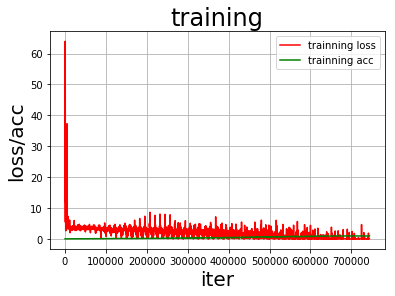

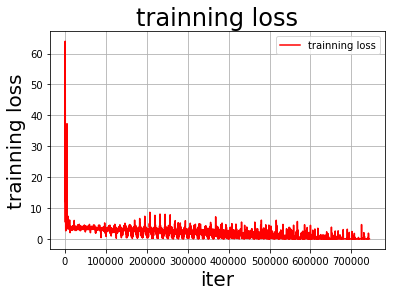

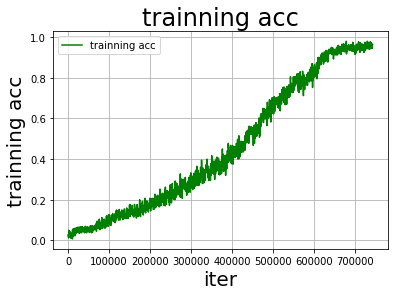

Final loss: [0.11273768]


In [14]:
 

'''
模型训练
'''
# place=fluid.CUDAPlace(0)    #表示使用GPU进行训练；不设置表示使用CPU进行训练
with fluid.dygraph.guard(place=fluid.CUDAPlace(0) ):   
                            
    print(train_parameters['class_dim'])
    print(train_parameters['label_dict'])

    #选择模型
    # cnn = VGGNet('VGGNet')     #name_scope大概就是传一个名字进去?
    # cnn = MyCNN()
    cnn = resnet50()
    optimizer=fluid.optimizer.AdamOptimizer(learning_rate=train_parameters['learning_strategy']['lr'],
                                                parameter_list=cnn.parameters())# 
    for epoch_num in range(train_parameters['num_epochs']):
        for batch_id, data in enumerate(train_reader()):
            dy_x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 3, 64, 64)
            y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)

            #将Numpy转换为DyGraph接收的输入
            img = fluid.dygraph.to_variable(dy_x_data)
            label = fluid.dygraph.to_variable(y_data)

            out = cnn(img)
            #计算精度和损失
            acc=fluid.layers.accuracy(out,label)
            loss = fluid.layers.cross_entropy(out, label)
            avg_loss = fluid.layers.mean(loss)

            #使用backward()方法可以执行反向网络
            avg_loss.backward()
            optimizer.minimize(avg_loss)  # 参数优化方法
             
            #将参数梯度清零以保证下一轮训练的正确性
            cnn.clear_gradients()
            
            all_train_iter=all_train_iter+train_parameters['train_batch_size']
            all_train_iters.append(all_train_iter)
            all_train_costs.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
                
            if batch_id % 30 == 0:
                print("Loss at epoch {} step {}: loss={}, acc={}".format(epoch_num, batch_id, avg_loss.numpy(), acc.numpy()))
    draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning loss","trainning acc")  
    draw_process("trainning loss","red",all_train_iters,all_train_costs,"trainning loss")
    draw_process("trainning acc","green",all_train_iters,all_train_accs,"trainning acc")
    #保存模型参数
    fluid.save_dygraph(cnn.state_dict(), "cnn")   
    print("Final loss: {}".format(avg_loss.numpy()))


In [18]:
'''
模型校验
'''
with fluid.dygraph.guard():
    model, _ = fluid.load_dygraph("cnn")
    #修改模型
    cnn = resnet50()
    # cnn = VGGNet('VGGNet')
    # cnn = MyCNN()
    cnn.load_dict(model)
    cnn.eval()
    accs = []
    for batch_id, data in enumerate(eval_reader()):
        # dy_x_data = np.array([x[0] for x in data]).astype('float32')
        # y_data = np.array([x[1] for x in data]).astype('int')
        # y_data = y_data[:, np.newaxis]
        
        dy_x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 3, 64, 64)
        y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)
        
        img = fluid.dygraph.to_variable(dy_x_data)
        label = fluid.dygraph.to_variable(y_data)

        out = cnn(img)
        acc=fluid.layers.accuracy(out,label)#计算精度
        lab = np.argsort(out.numpy())
        accs.append(acc.numpy()[0])
print(np.mean(accs))

0.245625


# **五、模型预测**

In [16]:

def get_infer_data_list(target_path,test_list_path):
    '''
    生成数据列表
    '''

    #获取所有类别保存的文件夹名称
    infer_list_path=target_path+"test/"
    infer_dirs = os.listdir(infer_list_path)  
    
    #存储要写进test.txt中的内容
    test_list=[]
    infer_sum=0 

    #读取test的图像路径
    for infer_dir in infer_dirs:
            if infer_dir != ".DS_Store":
                # 获取所有图片              
                infer_sum += 1
                img_path = infer_list_path  + 'test' +  '%d'%infer_sum + '.jpg'                    # 遍历文件夹下的每个图片     
                test_list.append(img_path+"\n") 

    with open(test_list_path, 'a') as f3:
        for infer_image in test_list:
            f3.write(infer_image) 

    print ('生成测试集数据列表完成！')



In [17]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path + "test")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((64, 64), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                   # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data35095/test.zip'
infer_dst_path = '/home/aistudio/data/'
unzip_infer_data(infer_src_path,infer_dst_path)

label_dic = train_parameters['label_dict']


'''
图像数据读取
'''
#对预测图片进行预处理
infer_imgs = []

with open(test_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 

get_infer_data_list(target_path,test_list_path)


with open(test_list_path, 'r') as f:
    lines = [line.strip() for line in f]
    for line in lines:
        img_path= line.strip()
        img = Image.open(img_path) 
        infer_imgs.append(load_image(img_path))

infer_imgs = np.array(infer_imgs)


'''
模型预测
'''
with fluid.dygraph.guard():
    model, _ = fluid.dygraph.load_dygraph("cnn")
    #这块要改一下模型的选择
    # cnn = VGGNet('VGGNet')
    cnn = resnet50()
    cnn.load_dict(model)
    cnn.eval()
    
    # #展示预测图片
    # infer_path='data/test/test280.jpg'
    # img = Image.open(infer_path)
    # plt.imshow(img)          #根据数组绘制图像
    # plt.show()               #显示图像


    for  i in range(len(infer_imgs)):
        data = infer_imgs[i]
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        out = cnn(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
        print("第{}个样本,被预测为：{}".format(i+1,label_dic[str(lab)]))
        
print("结束")


生成测试集数据列表完成！
第1个样本,被预测为：29
第2个样本,被预测为：22
第3个样本,被预测为：37
第4个样本,被预测为：26
第5个样本,被预测为：5
第6个样本,被预测为：14
第7个样本,被预测为：14
第8个样本,被预测为：31
第9个样本,被预测为：25
第10个样本,被预测为：29
第11个样本,被预测为：24
第12个样本,被预测为：18
第13个样本,被预测为：37
第14个样本,被预测为：22
第15个样本,被预测为：27
第16个样本,被预测为：4
第17个样本,被预测为：19
第18个样本,被预测为：14
第19个样本,被预测为：28
第20个样本,被预测为：15
第21个样本,被预测为：5
第22个样本,被预测为：15
第23个样本,被预测为：28
第24个样本,被预测为：16
第25个样本,被预测为：36
第26个样本,被预测为：14
第27个样本,被预测为：10
第28个样本,被预测为：15
第29个样本,被预测为：8
第30个样本,被预测为：15
第31个样本,被预测为：21
第32个样本,被预测为：15
第33个样本,被预测为：32
第34个样本,被预测为：39
第35个样本,被预测为：39
第36个样本,被预测为：32
第37个样本,被预测为：38
第38个样本,被预测为：28
第39个样本,被预测为：25
第40个样本,被预测为：24
第41个样本,被预测为：17
第42个样本,被预测为：15
第43个样本,被预测为：18
第44个样本,被预测为：16
第45个样本,被预测为：9
第46个样本,被预测为：29
第47个样本,被预测为：27
第48个样本,被预测为：18
第49个样本,被预测为：23
第50个样本,被预测为：3
第51个样本,被预测为：17
第52个样本,被预测为：15
第53个样本,被预测为：2
第54个样本,被预测为：35
第55个样本,被预测为：19
第56个样本,被预测为：31
第57个样本,被预测为：18
第58个样本,被预测为：35
第59个样本,被预测为：38
第60个样本,被预测为：25
第61个样本,被预测为：26
第62个样本,被预测为：1
第63个样本,被预测为：14
第64个样本,被预测为：19
第65个样本,被预测为：27
第66个样本,被预测为：3
第67个样本,被预测为：35
